In [2]:
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parent.as_posix())

from matplotlib import pyplot as plt
import numpy as np
from numpy import typing as npt
from typing import TypedDict
from utils.oscilloscope import Oscilloscope, plot_data
from rberga06.phylab import Datum as d

In [3]:
class DataSet(TypedDict):
    R: float
    Freq: npt.NDArray[np.float64]
    V: list[tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]]

In [10]:
all_data_day1 = [Oscilloscope.Elettr.load_data(
    i, dir="data/day1", plot_dir="elab/day1",
    del_data_slices=(slice(-3, None),) if i in (0, 1, 3) else (),
) for i in range(51)]

all_data_day2 = [Oscilloscope.Elettr.load_data(
    i, dir="data/day2", plot_dir="elab/day2",
) for i in range(27)]

In [7]:
dati: list[DataSet] = [{
    "R": 1.e3,  # Ohm
    "Freq": np.array([
        np.nan, 1., 4.96, np.nan, np.nan, 10.2, 20.10, 50.13, 100.2, 200.0, 500.3, 1.004e3,
        np.nan, np.nan, 2.000e3, 5.000e3, 7.500e3, 10.000e3,
        15.e3, # forse qualitativo?
        20.02e3,
        # manca un 25.02 kHz
        30.01e3, 49.99e3, 99.99e3, 200.1e3, 499.9e3, 999.9e3, 5.001e6,
    ]),
    # "dFreq": np.array([.01, .01, .1, .01, .01, .1, .1, .3, .001e3]),
    "V": all_data_day1[0:27],
},
# {
#     "R": 1.e3,
#     "Freq": np.array([]),
#     "V": all_data_day2[0:],
# }, {
#     "R": 1.e3,
#     "Freq": np.array([]),
#     "V": all_data_day2[0:0],
# }
#{
    # R = 100 Ohm
    # "Freq": np.array([1., ])
#}
]

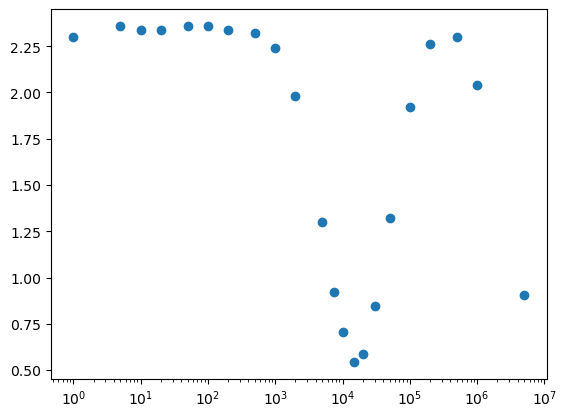

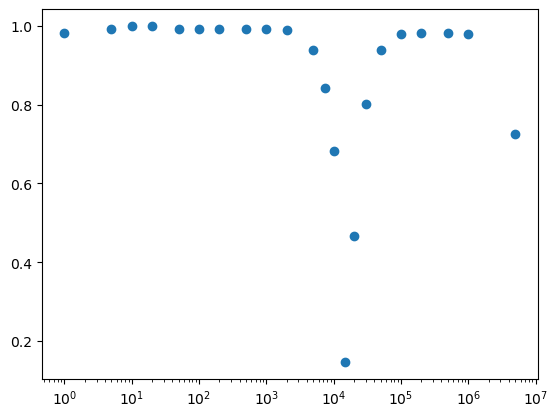

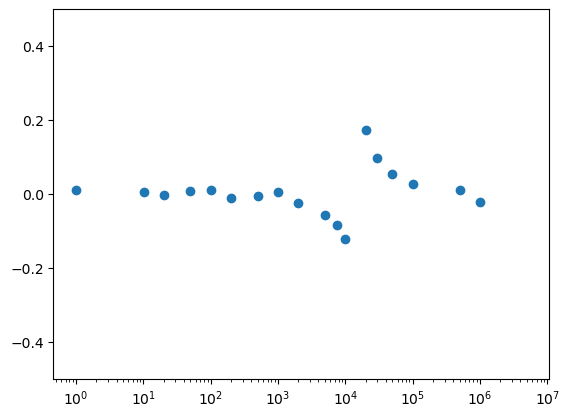

In [12]:
for set_di_dati in dati:
    frequenze = []
    ampiezze_ch1 = []
    ampiezze_ch2 = []
    sfasamenti = []
    for f, (t, ch1, ch2) in zip(set_di_dati["Freq"], set_di_dati["V"], strict=True):
        if np.isnan(f):
            continue
        ampiezze_ch1.append(max(np.nanmax(ch1), -np.nanmin(ch1)))
        ampiezze_ch2.append(max(np.nanmax(ch2), -np.nanmin(ch2)))
        frequenze.append(f)
        fase = (t[np.nanargmin(ch1)] - t[np.nanargmin(ch2)]) * f
        # while fase > .5: fase -= 1
        # while fase < -.5: fase += 1
        sfasamenti.append(fase)
    ampiezze_ch1 = np.array(ampiezze_ch1)
    ampiezze_ch2 = np.array(ampiezze_ch2)

    plt.scatter(frequenze, ampiezze_ch1)
    plt.xscale("log")
    plt.show()
    plt.scatter(frequenze, ampiezze_ch2 / ampiezze_ch1)
    plt.xscale("log")
    plt.show()
    plt.scatter(frequenze, sfasamenti)
    plt.xscale("log")
    plt.ylim((-0.5, 0.5))
    plt.show()